In [13]:
from classy import Class
import math
import matplotlib.pyplot as plt
from math import pi
import numpy as np
import pandas as pd

#### Initiate CLASS

In [2]:
LambdaCDM = Class()
LambdaCDM.set({'output':'tCl,pCl,lCl,mPk','P_k_max_1/Mpc':10.0,'z_pk':2.})
LambdaCDM.compute()

#### Initialize variables for $V_{eff}$ calculation

In [144]:
# SDSS values
h = LambdaCDM.h()
Vsurv_sdss = 1e9
meann_sdss = 1e-4
z_sdss = 0.3
kmax_sdss = 0.1

#### Compute and plot 2D power spectrum: $P(k,z)$

In [145]:
def pk(kmax,z):
    kk = np.logspace(-4,np.log10(kmax),1000) # k in h/Mpc
    Pk0 = [] # default, z=0
    Pk = [] # for varied z
    for k in kk:
        Pk0.append(LambdaCDM.pk(k,0.)) 
        Pk.append(LambdaCDM.pk(k,z)) 
    if 0: 
        plt.figure(2)
        plt.xlim(kk[0],kk[-1])
        plt.xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$')
        plt.ylabel(r'$P(k) \,\,\,\, [\mathrm{Mpc}/h]^3$')
        plt.loglog(kk,Pk0,'b-')
        plt.loglog(kk,Pk,'r-')
        plt.show()
    
    return kk,Pk0,Pk

In [146]:
kk, Pk0, Pk = pk(0.5,z_sdss)

#### Compute and plot 2D effective volume: $V_{eff}$

In [147]:
def Veff(k,z,kmax,Vsurv):
    kk,Pk0,Pk = pk(kmax,z)
    index = np.where(kk==k)[0][0]
    return pow((meann*Pk[index])/(meann*Pk[index]+1),2.)*Vsurv

In [149]:
Vs = []
for k in kk:
    Vs.append(Veff(k,z_sdss,0.5,Vsurv_sdss))

In [150]:
Vs

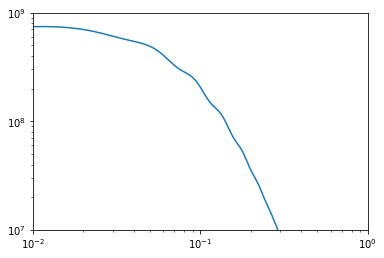

In [151]:
plt.xlim(0.01,1)
plt.ylim(1e7,1e9)
plt.loglog(kk,Vs)

---

In [55]:
omm=0.27
omb=0.046
oml=1.0-omm
wl = oml
wr = 0
Mnu=0.3
h=0.72
omnu=0.2/h/h
tau=0.1
nscal=0.963
alpha=0.0
ascal2=29.5
ascal2*=0.9
ts=0.0
w0=-1.0
w = w0
w1=0.0
wa = w1
sigma8=0.809
omega0 = 0.3
lambda0 = 0.7    
omegak=1.0-omega0+lambda0

In [44]:
def coordDistance(zCall):
    if (abs(omega0-1.0) < 1.0e-5 and abs(lambda0) < 1.0e-5):
        cDist = 2.0*(1.0 - 1.0/sqrt(1.0 + zCall))
    elif (abs(omega0 + lambda0 - 1.0) < 1.0e-5):
        cDist = confTime(0.0) - confTime(zCall)
    elif (omega0 < 1.0 and abs(lambda0) < 1.0e-5):
        cDist = 2.0*(omega0*zCall + (omega0 - 2.0)*(sqrt(1.0+omega0*zCall) - 1.0))
        cDist /= omega0*omega0*(1.0 + zCall)
    else:
        print("Invalid cosmology in coordDistance!")
        cDist=coordDistanceNum(zCall)
        return cDist
    return cDist

In [45]:
def angDiamDist(zCall):
    cDist=coordDistance(zCall)

    if(omegak>1.0e-5):
        return sinh(sqrt(omegak)*cDist)/(1.0+zCall)/sqrt(omegak)
    elif(omegak<1.0e-5):
        return sin(sqrt(-omegak)*cDist)/(1.0+zCall)/sqrt(-omegak)
    else:
        return cDist/(1.0+zCall)    

In [46]:
def Omegamz(z,wm):
    return wm * pow(1+z,3)

In [47]:
def OmegaLambdaz(z,wl,w,wa):
    if (wa !=0):
        lamZ = wl*pow(1+z,3.0*(1.0+w+wa)) * math.exp(-3.0*wa*z/(1+z))
    else:
        lamZ= wl *pow(1+z,3*(1+w))
    return lamZ   

In [48]:
def Eofz(wm,wl,wr,w,wa,z):
    return math.sqrt(Omegamz(z,wm) + OmegaLambdaz(z,wl,w, wa)+ wr*pow(1+z,4))

In [49]:
def fff(x):
    return pow(x,3)*(log(1.0+1.0/x)-1.0/(1.0+x))

In [50]:
def M200toM500(M200):
    a = [0.5116,-0.4283,-3.13e-3,-3.52e-5]
    c=5.0
    f_h=200.0/500.0 *fff(1.0/c)
    p=a[1] + a[2]*log(f_h)+a[3]*log(f_h)*log(f_h)
    xoff=1.0/sqrt(a[0]*pow(f_h,2.0*p)+9.0/16.0) +2.0*f_h
    return M200*500/200 * pow(c*xoff,3.0)

In [51]:
def mlim(ommhh, wl, wr, w, wa, z):
    omhh = ommhh

    h = math.sqrt(omhh/(1-wl))
    wm = omhh/(h*h)
    da = angDiamDist(z)*cl*1e-5
    E = Eofz(wm,wl,wr,w,wa, z)
    mlim=0
    Ylim_planck=2e-3
    masscut=8e13
    
    if(z != 0):
        mlim=(1e15)*pow(da*da*pow(E,-2./3.)*(Ylim_planck*pow(d2r/60,2)/2.504e-4), 1./1.876)
    
    mmin=M200toM500(mlim)
    
    if (mmin <= masscut):
        return masscut
    else:
        return mmin

In [52]:
def NFR(frflag,h,wa,w,wmmmhh, wlll, wbbbhh,
        wrrr,  sigmaa8, nspecc, zzz1, zzz2, 
        Mmm1, Mmm2,Bm0, sigma0, alpha, beta):
    zz= zzz1
    intz= (zzz2-zzz1)/50.
    
    for k in range(50):
        ml=cal_mlim(wmmmhh,wlll,wrrr,w,wa,zz)
        result += NofzFR(frflag,wa,w,wmmmhh,wlll,wbbbhh,wrrr,sigmaa8,nspecc,zz,Mmm1,ml,Bm0,sigma0,alpha,beta) * intz
        zz +=intz 

    return result

In [53]:
#todo
def NofzFR(frflag, wa, w, wmmmhh, wlll, wbbbhh, wrrr, sigmaa8,
           nspecc, zzz, Mmm1, Mmm2, Bm0, sigma0, alpha, beta):
    double MassF=0, 
    deltaM=pow(10,0.05),
    xm1=0, 
    xm2=0, 
    Bm=0.1, 
    sigmaMM=0.1, 
    Md=0
    double NNN=0,
    nn=1
    double omnu = 0.0
    double h=sqrt(wmmmhh/(1-wlll))
    Cosmology my_cosmo(wmmmhh/(h*h), wlll, wbbbhh/(h*h), h, sigmaa8, nspecc, omnu, w, wa)

    Bm=Bm0*pow((1+zzz),alpha)
    sigmaMM=sigma0*pow((1+zzz),beta)
    Md=1e13

    for k in range(100):
    if (frflag) nn=findNnn(zzz,Md,FR_name, wmmmhh/(h*h))
    if (nn <1) nn=1
    MassF=nn*my_cosmo.dndlMTinker(zzz,Md)/Md
    xm1=(log(Mmm1)-Bm-log(Md))/(sqrt(2)*sigmaMM)
    xm2=(log(Mmm2)-Bm-log(Md))/(sqrt(2)*sigmaMM)
    NNN +=MassF*Md *(deltaM-1) *(erfc(xm2)-erfc(xm1))
    Md *=deltaM

    return NNN*ComovingVolume(zzz,wmmmhh,wrrr,wlll,w, wa)/2.0

SyntaxError: invalid syntax (<ipython-input-53-a28406b36b6b>, line 4)

In [54]:
mlim(omm*h*h, wl, wr, w, wa, 0.1)

NameError: global name 'omega0' is not defined

---

In [29]:
df = pd.read_csv('example.csv',header=-1)
df.head()

,0,1
0,0.001,17198.3
1,0.002,31471.5
2,0.003,43009.9
3,0.004,52158.0
4,0.005,59313.6


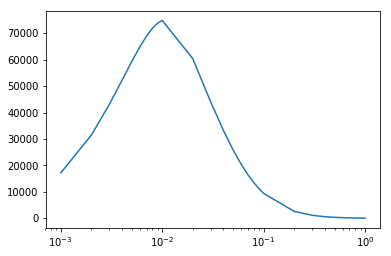

In [30]:
plt.semilogx(np.array(df[0]),np.array(df[1]))